### IMPORTS:

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from random import randint
from tensorflow.keras.models import load_model
import pickle
from sklearn.metrics import classification_report, confusion_matrix


### Importing datasets:

C:\Users\tutuz\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 150 (\x96) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


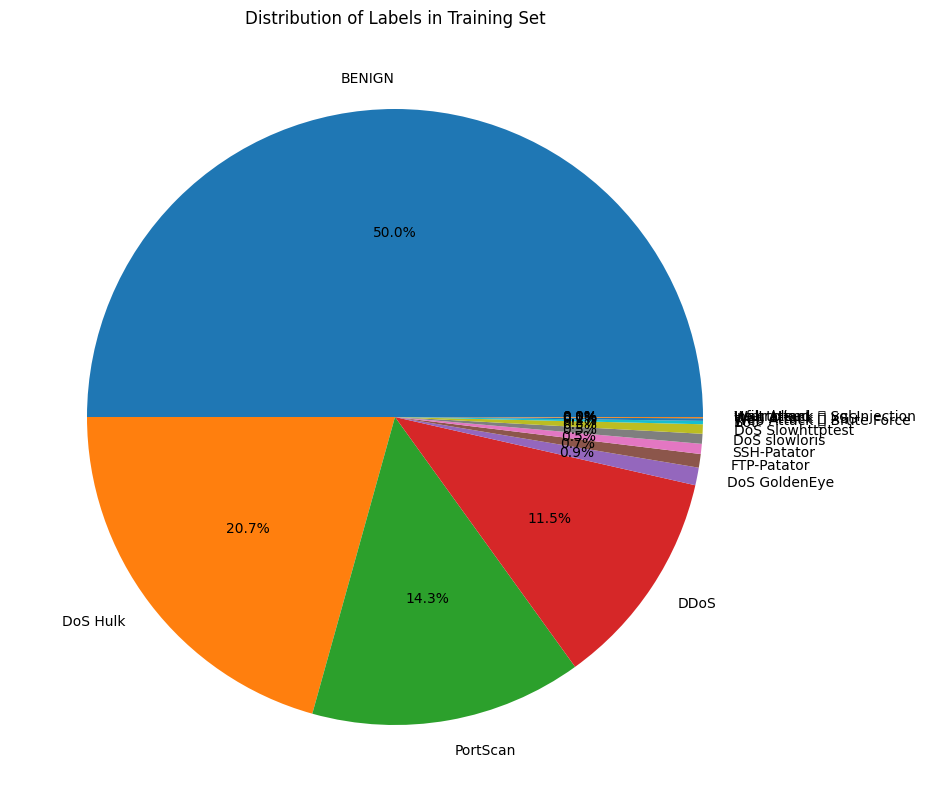

 Label
BENIGN                        278274
DoS Hulk                      115062
PortScan                       79402
DDoS                           64012
DoS GoldenEye                   5146
FTP-Patator                     3967
SSH-Patator                     2948
DoS slowloris                   2898
DoS Slowhttptest                2749
Bot                              978
Web Attack  Brute Force         753
Web Attack  XSS                 326
Infiltration                      18
Web Attack  Sql Injection        10
Heartbleed                         5
Name: count, dtype: int64


In [4]:
df_train = pd.read_parquet("parquet/train_set.parquet")
df_cross_validation = pd.read_parquet("parquet/crossval_set.parquet")
df_test = pd.read_parquet("parquet/test_set.parquet")



# Pie chart 
label_counts = df_train[' Label'].value_counts()
plt.figure(figsize=(10, 10))
plt.pie(label_counts.values, labels=label_counts.index, autopct='%1.1f%%')
plt.title('Distribution of Labels in Training Set')
plt.show()
print(label_counts)

---

### DATA CLEANUP:

#### Arrumando os nomes começando com espaços

In [5]:
df_train.columns = df_train.columns.str.strip().str.lower()

df_cross_validation.columns = df_cross_validation.columns.str.strip().str.lower()

df_test.columns = df_test.columns.str.strip().str.lower()


#### Removendo colunas com NaN

In [6]:
print(len(df_train), len(df_cross_validation), len(df_test))
df_train.dropna(inplace=True)
df_cross_validation.dropna(inplace=True)
df_test.dropna(inplace=True)
print(len(df_train), len(df_cross_validation), len(df_test))

556548 278270 278270
556548 278270 278270


#### Feature selection

In [8]:
columns = [
    'bwd psh flags',
    'bwd urg flags', 
    'fwd avg bytes/bulk',
    'fwd avg packets/bulk',
    'fwd avg bulk rate',
    'bwd avg bytes/bulk', 
    'bwd avg packets/bulk',
    'bwd avg bulk rate',
    'timestamp',
]

print(f"Size before dropping: {len(df_train.columns)}")
df_train = df_train.drop(columns=columns)
print(f"Size after dropping: {len(df_train.columns)}")

df_cross_validation = df_cross_validation.drop(columns=columns)

Size before dropping: 85
Size after dropping: 76


### Data Standardization

In [9]:
print(f"Not numeric columns and values:")
categorical_columns = []
for col in df_train.columns:
    if df_train[col].dtype != 'float64':
        categorical_columns.append(col)
        print(f"{col}: {df_train[col].dtype} - {df_train[col].nunique()}")
print(f"Not numeric columns array: {categorical_columns}")





Not numeric columns and values:
flow id: object - 336517
source ip: object - 8948
destination ip: object - 12359
label: object - 15
Not numeric columns array: ['flow id', 'source ip', 'destination ip', 'label']


We will drop no numeric columns to scale the dataset, but we can't drop the label

In [10]:
if 'label' in categorical_columns:
    categorical_columns.remove('label')
    
df_train = df_train.drop(columns=categorical_columns)
df_cross_validation = df_cross_validation.drop(columns=categorical_columns)

X = df_train.drop(['label'], axis = 1)
y = df_train['label']
X_crossval = df_cross_validation.drop(['label'], axis = 1)
y_crossval = df_cross_validation['label']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
df_train_scaled = pd.concat([X_scaled, y], axis=1)

X_crossval_scaled = scaler.transform(X_crossval)
X_crossval_scaled = pd.DataFrame(X_crossval_scaled, columns=X_crossval.columns, index=X_crossval.index)
df_crossval_scaled = pd.concat([X_crossval_scaled, y_crossval], axis=1)

### Label Encoder
y.values must become numbers so we can conver them to torch tensors

In [11]:
print(y.values)
label_encoder = LabelEncoder()
y_numeric = label_encoder.fit_transform(y.values)
y_crossval_numeric = label_encoder.transform(y_crossval.values)
for i, label in enumerate(label_encoder.classes_):
    print(f"{label}: {i}")


['DoS Slowhttptest' 'PortScan' 'BENIGN' ... 'DoS Hulk' 'BENIGN' 'BENIGN']
BENIGN: 0
Bot: 1
DDoS: 2
DoS GoldenEye: 3
DoS Hulk: 4
DoS Slowhttptest: 5
DoS slowloris: 6
FTP-Patator: 7
Heartbleed: 8
Infiltration: 9
PortScan: 10
SSH-Patator: 11
Web Attack  Brute Force: 12
Web Attack  Sql Injection: 13
Web Attack  XSS: 14


Input layer: 72 vs (73|70)

First hidden layer: 256 neurons
- Activation: SELU (Scaled Exponential Linear Unit)
- λ = 1.0507 and α = 1.6733

Second hidden layer: 256 neurons
- Activation: SELU (Scaled Exponential Linear Unit)
- λ = 1.0507 and α = 1.6733

Output layer: 15 neurons
- Activation: Softmax

Mini Batches of 32 instances

Loss function: Categorical cross-entropy

Optimizer: Adam algorithm (Alpha: Learning rate, Beta1, Beta2)??
nn_desc.hyper_param.optim_params = [0.001, 0.9, 0.999]
Dropout: 0.833910013348719 or 0.5


In [15]:
y_onehot = to_categorical(y_numeric)
y_crossval_onehot = to_categorical(y_crossval_numeric)

model = Sequential([
    Dense(256, input_dim=X_scaled.shape[1], activation='selu'),
    BatchNormalization(),
    Dropout(0.833910013348719),
    
    Dense(256, activation='selu'),
    BatchNormalization(),
    Dropout(0.833910013348719),
    
    Dense(len(label_encoder.classes_), activation='softmax')
])

optimizer = Adam(
    learning_rate=0.01,
    beta_1=0.9,
    beta_2=0.999
)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.0001
)

history = model.fit(
    X_scaled.values, y_onehot,
    epochs=100,
    batch_size=32,
    verbose=1,
    validation_data=(X_crossval_scaled.values, y_crossval_onehot),
    callbacks=[early_stopping, reduce_lr]
)

y_pred = model.predict(X_scaled.values)
accuracy = tf.keras.metrics.categorical_accuracy(y_onehot, y_pred)
print(f"\nAccuracy: {tf.reduce_mean(accuracy).numpy():.4f}")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 256)            │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 90,383 (353.06 KB)

 Trainable params: 89,359 (349.06 KB)

 Non-trainable params: 1,024 (4.00 KB)

Epoch 1/100
17393/17393 ━━━━━━━━━━━━━━━━━━━━ 38s 2ms/step - accuracy: 0.8624 - loss: 0.5024 - val_accuracy: 0.6854 - val_loss: 0.7763 - learning_rate: 0.0100
Epoch 2/100
17393/17393 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - accuracy: 0.9163 - loss: 0.2945 - val_accuracy: 0.9623 - val_loss: 0.1204 - learning_rate: 0.0100
Epoch 3/100
17393/17393 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - accuracy: 0.9251 - loss: 0.2647 - val_accuracy: 0.9514 - val_loss: 0.1243 - learning_rate: 0.0100
Epoch 4/100
17393/17393 ━━━━━━━━━━━━━━━━━━━━ 38s 2ms/step - accuracy: 0.9292 - loss: 0.2526 - val_accuracy: 0.9671 - val_loss: 0.1035 - learning_rate: 0.0100
Epoch 5/100
17393/17393 ━━━━━━━━━━━━━━━━━━━━ 39s 2ms/step - accuracy: 0.9338 - loss: 0.2402 - val_accuracy: 0.9500 - val_loss: 0.1608 - learning_rate: 0.0100
Epoch 6/100
17393/17393 ━━━━━━━━━━━━━━━━━━━━ 39s 2ms/step - accuracy: 0.9352 - loss: 0.2323 - val_accuracy: 0.9703 - val_loss: 0.1065 - learning_rate: 0.0100
Epoch 7/100
17393/17393 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms

KeyboardInterrupt: 

In [16]:
model.save(f'{randint(0,10000000)}.keras')


In [31]:
model_name = "479746.keras"  

# LOAD
model = load_model(model_name)
print(f"Loaded model: {model_name}")

with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)
with open('label_encoder.pkl', 'rb') as f:
    label_encoder = pickle.load(f)


df_test = pd.read_parquet("parquet/test_set.parquet")

Loaded model: 479746.keras


In [32]:
# CLEANUP 
df_test.columns = df_test.columns.str.strip().str.lower()
print(f"Test set size before dropping: {len(df_test)}")
df_test.dropna(inplace=True)
print(f"Test set size after dropping: {len(df_test)}")

columns_to_drop = [
    'bwd psh flags',
    'bwd urg flags', 
    'fwd avg bytes/bulk',
    'fwd avg packets/bulk',
    'fwd avg bulk rate',
    'bwd avg bytes/bulk', 
    'bwd avg packets/bulk',
    'bwd avg bulk rate',
    'timestamp',
    'flow id',
    'source ip',
    'destination ip',
]

df_test = df_test.drop(columns=columns_to_drop)


X_test = df_test.drop(['label'], axis=1)
y_test = df_test['label']

X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

Test set size before dropping: 278270
Test set size after dropping: 278270


In [33]:
# ENCODER
y_test_numeric = label_encoder.transform(y_test)
y_test_onehot = to_categorical(y_test_numeric)
print("\nLabel Mapping:")
for i, label in enumerate(label_encoder.classes_):
    print(f"{label}: {i}")


Label Mapping:
BENIGN: 0
Bot: 1
DDoS: 2
DoS GoldenEye: 3
DoS Hulk: 4
DoS Slowhttptest: 5
DoS slowloris: 6
FTP-Patator: 7
Heartbleed: 8
Infiltration: 9
PortScan: 10
SSH-Patator: 11
Web Attack  Brute Force: 12
Web Attack  Sql Injection: 13
Web Attack  XSS: 14


In [34]:
# TEST
print("\nTest Set Evaluation:")
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test_onehot, verbose=1)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")

y_pred = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test_onehot, axis=1)

conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

# attack vs benign
benign_idx = np.where(label_encoder.classes_ == 'BENIGN')[0][0]
y_true_binary = np.array(y_test_classes != benign_idx, dtype=int)
y_pred_binary = np.array(y_pred_classes != benign_idx, dtype=int)

# cf matrix
bin_conf_matrix = confusion_matrix(y_true_binary, y_pred_binary)
tn, fp, fn, tp = bin_conf_matrix.ravel()


# metrics
tn_rate = tn / (tn + fp) * 100
fp_rate = fp / (fp + tn) * 100 
recall = tp / (tp + fn) * 100 
precision = tp / (tp + fp) * 100 
accuracy = (tp + tn) / (tp + tn + fp + fn) * 100
f1 = 2 * (precision * recall) / (precision + recall) 

print("\nOverall Metrics (Attack vs Benign):")
print(f"True Positives: {tp}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Negatives: {tn}")
print(f"True Negative Rate: {tn_rate:.2f}%")
print(f"False Positive Rate: {fp_rate:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"Precision: {precision:.2f}%")
print(f"Accuracy: {accuracy:.2f}%")
print(f"F1-score: {f1:.2f}%")


print("\nPer-Class:")
print(classification_report(y_test_classes, y_pred_classes, target_names=label_encoder.classes_))


Test Set Evaluation:
8696/8696 ━━━━━━━━━━━━━━━━━━━━ 8s 942us/step - accuracy: 0.9942 - loss: 0.0195
Test loss: 0.0197
Test accuracy: 0.9943
8696/8696 ━━━━━━━━━━━━━━━━━━━━ 6s 686us/step

Overall Metrics (Attack vs Benign):
True Positives: 138434
False Positives: 796
False Negatives: 701
True Negatives: 138339
True Negative Rate: 99.43%
False Positive Rate: 0.57%
Recall: 99.50%
Precision: 99.43%
Accuracy: 99.46%
F1-score: 99.46%

Per-Class:
                            precision    recall  f1-score   support

                    BENIGN       0.99      0.99      0.99    139135
                       Bot       0.94      0.94      0.94       489
                      DDoS       1.00      1.00      1.00     32006
             DoS GoldenEye       0.99      0.98      0.99      2573
                  DoS Hulk       0.99      1.00      0.99     57531
          DoS Slowhttptest       0.97      0.98      0.97      1374
             DoS slowloris       0.99      0.99      0.99      1449
           

c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
